In [1]:
import pickle
from pathlib import Path

import pandas as pd
import numpy as np
from pulearn.elkanoto import ElkanotoPuClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.decomposition import PCA
from tqdm import tqdm

import pul_config
import importlib
importlib.reload(pul_config)

def predict_proba(m, X):
    try:
        proba = m.predict_proba(X)
    except:
        try:
            proba = m.decision_function(X)
        except:
            proba = m.best_estimator_.decision_function(X)

    return proba

def evaluate(m, X, y, n=100, scale=True):
    y_pred = m.predict(X) > 0
    y_prob_pred = predict_proba(m, X)

    order = np.argsort(y_prob_pred)[::-1]
    # print(y_pred[order][:n])
    if scale:
        return y[order][:n].sum() / y.sum()
    else:
        return y[order][:n].sum()
    

# CHANGE HERE
input_dirs = [Path('1_outputs/standard/'), Path('1_outputs/small_DS/')]
output_dirs = [Path('2_outputs/standard/'), Path('2_outputs/small_DS/')]
method = 'local_outlier_factor'
pul_cfg = pul_config.LocalOutlierFactorConfig
# -----

MODEL_NAMES = ('RotatE', 'TransE')
output_dirs = [output_dir / method for output_dir in output_dirs]

## Training

In [4]:
np.random.seed(42)

In [16]:
def train(input_dir, output_dir, n_jobs, cv, model_names, rerun=False):
    ref_df = pd.read_csv(input_dir / 'ref_df.csv', index_col=0)
    ref_df.head()
    for model_name in tqdm(model_names):
        out_dir = output_dir / model_name
        out_dir.mkdir(exist_ok=True, parents=True)
        for i in tqdm(range(10)):
            m_file = out_dir / f'{model_name}_{i}.pkl'
            print(m_file.exists())
            if m_file.exists():
                try:
                    # try to load the file
                    with open(m_file, 'rb') as f:
                        pickle.load(f)
                    if not rerun:
                        print(m_file, 'exists. Skipping...')
                        continue
                except:
                    pass

            X_all = np.load(input_dir / f'{model_name}_X_{i}.npy')

            ds_names = ('train', 'test', 'val')
            Xs = {ds: X_all[ref_df.query(ds)['id']] for ds in ds_names}
            ys = {ds: ref_df.query(ds)['y'].values for ds in ds_names}

            ds = 'train'
            X = Xs[ds]
            y = ys[ds]

            pipe = pul_cfg.build_pipeline()
            param_grid = pul_cfg.build_param_grid()

            grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=cv, refit=True, n_jobs=n_jobs, scoring=evaluate)
            grid_search.fit(X=X, y=y)

            with open(m_file, 'wb') as f:
                pickle.dump(grid_search, f)

In [ ]:
N_JOBS = 20
CV = 5

for input_dir, output_dir in tqdm(zip(input_dirs, output_dirs), total=len(input_dirs)):
    train(input_dir=input_dir, output_dir=output_dir, model_names=MODEL_NAMES, cv=CV, n_jobs=N_JOBS)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 16.04it/s]

True
2_outputs/standard/local_outlier_factor/RotatE/RotatE_0.pkl exists. Skipping...
True
2_outputs/standard/local_outlier_factor/RotatE/RotatE_1.pkl exists. Skipping...
True
2_outputs/standard/local_outlier_factor/RotatE/RotatE_2.pkl exists. Skipping...
True




 40%|████      | 4/10 [00:00<00:00, 15.14it/s]

 60%|██████    | 6/10 [00:00<00:00, 14.92it/s]

2_outputs/standard/local_outlier_factor/RotatE/RotatE_3.pkl exists. Skipping...
True
2_outputs/standard/local_outlier_factor/RotatE/RotatE_4.pkl exists. Skipping...
True
2_outputs/standard/local_outlier_factor/RotatE/RotatE_5.pkl exists. Skipping...
True




 80%|████████  | 8/10 [00:00<00:00, 11.77it/s]

2_outputs/standard/local_outlier_factor/RotatE/RotatE_6.pkl exists. Skipping...
True
2_outputs/standard/local_outlier_factor/RotatE/RotatE_7.pkl exists. Skipping...
True
2_outputs/standard/local_outlier_factor/RotatE/RotatE_8.pkl exists. Skipping...
True




100%|██████████| 10/10 [00:00<00:00, 12.26it/s]

 50%|█████     | 1/2 [00:00<00:00,  1.21it/s]

2_outputs/standard/local_outlier_factor/RotatE/RotatE_9.pkl exists. Skipping...




  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:01,  8.48it/s]

True
2_outputs/standard/local_outlier_factor/TransE/TransE_0.pkl exists. Skipping...
True




 20%|██        | 2/10 [00:00<00:00,  8.32it/s]

2_outputs/standard/local_outlier_factor/TransE/TransE_1.pkl exists. Skipping...
False




 30%|███       | 3/10 [03:58<12:42, 108.93s/it]

False




 40%|████      | 4/10 [07:49<15:41, 156.90s/it]

False




 50%|█████     | 5/10 [11:38<15:14, 182.89s/it]

False


## Evaluation

In [2]:
def load_grid_searches(output_dir, model_names):
    grid_searches = {}
    for model_name in model_names:
        grid_searches[model_name] = {}
        for j in range(10):
            m_name = f'{model_name}_{j}'
            m_file = output_dir / model_name / f'{m_name}.pkl'
            with open(m_file, 'rb') as f:
                grid_search = pickle.load(f)
            grid_searches[model_name][m_name] = grid_search

    return grid_searches

In [3]:
grid_searches_list = [
    load_grid_searches(output_dir=o, model_names=MODEL_NAMES) for o in output_dirs
]

In [4]:
def score_df_from_grid_searches(grid_searches, input_dir, ns=(10,100)):
    ref_df = pd.read_csv(input_dir / 'ref_df.csv', index_col=0)
    ref_df.head()

    score_dict = {
        'model_name': [],
        'm_name': [],
        'score10_val': [],
        'score100_val': [],
        'score10_test': [],
        'score100_test': [],

    }
    scale = False
    for model_name in grid_searches.keys():
        for i, m_name in enumerate(grid_searches[model_name].keys()):
            score_dict['model_name'].append(model_name)
            score_dict['m_name'].append(m_name)
            X_all = np.load(input_dir / f'{model_name}_X_{i}.npy')

            ds_names = ('train', 'test', 'val')
            Xs = {ds: X_all[ref_df.query(ds)['id']] for ds in ds_names}
            ys = {ds: ref_df.query(ds)['y'].values for ds in ds_names}

            grid_search = grid_searches[model_name][m_name]
            for n in ns:
                val_score = evaluate(
                    m=grid_search,
                    X=Xs['val'],
                    y=ys['val'],
                    n=n,
                    scale=scale
                )
                score_dict[f'score{n}_val'].append(val_score)

                test_score = evaluate(
                    m=grid_search,
                    X=Xs['test'],
                    y=ys['test'],
                    n=n,
                    scale=scale
                )
                score_dict[f'score{n}_test'].append(test_score)

    score_df = pd.DataFrame(score_dict)
    return score_df

In [5]:
score_dfs = [score_df_from_grid_searches(gs, i) for gs, i in zip(grid_searches_list, input_dirs)]
for output_dir, score_df in zip(output_dirs, score_dfs):
    score_df.to_csv(output_dir / 'score_df.csv')

KeyboardInterrupt: 

In [ ]:
score_dfs[0].groupby('model_name').mean()

In [ ]:
import seaborn as sns

sns.boxplot(score_dfs[0], x='model_name', y='score10_test').set(title='Hits@100 and hits@10\n(large positive set)')
sns.boxplot(score_dfs[0], x='model_name', y='score100_test').set_ylabel('score')

In [ ]:
score_dfs[1].groupby('model_name').mean()

In [ ]:
import seaborn as sns

sns.boxplot(score_dfs[1], x='model_name', y='score10_test').set(title='Hits@100 and hits@10\n(small positive set)')
sns.boxplot(score_dfs[1], x='model_name', y='score100_test').set_ylabel('score')

In [6]:
score_dfs = []
for output_dir in output_dirs:
    score_dfs.append(pd.read_csv(output_dir / 'score_df.csv', index_col=0))
plot_dfs = []
for ds, score_df in zip(('large', 'small'), score_dfs):
    plot_df = score_df[['model_name', 'score10_test', 'score100_test']].copy()
    plot_df.columns = ['model_name', 'hits@10', 'hits@100']
    plot_df['dataset'] = ds
    plot_dfs.append(plot_df)
    
plot_df = pd.concat(plot_dfs)
plot_df = plot_df.melt(id_vars=['model_name', 'dataset'])
plot_dfs = {k:v for k, v in plot_df.groupby('model_name')}

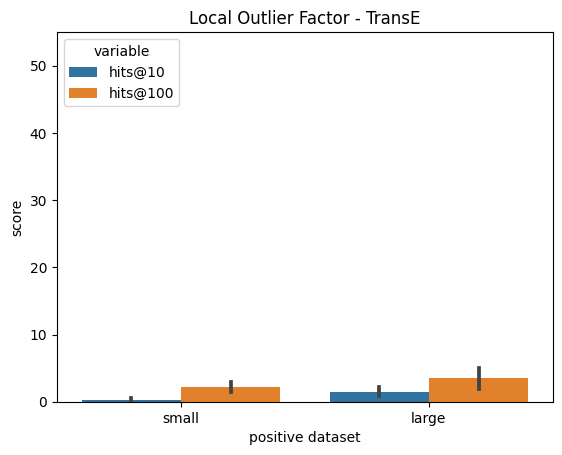

In [10]:
import seaborn as sns
model_name = 'TransE'
plot_df = plot_dfs[model_name]
plot = sns.barplot(plot_df, x='dataset', y='value', hue='variable', order=['small', 'large'])
sns.move_legend(plot, 'upper left')
plot.set(xlabel='positive dataset', ylabel='score')
plot.set_title(f'Local Outlier Factor - {model_name}')
plot.set_ylim([0, 55])
_ = plot.set_xticklabels(labels=['small', 'large'], rotation=0)

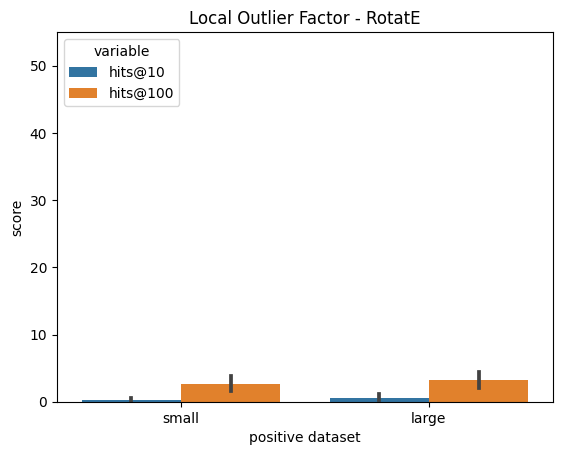

In [11]:
import seaborn as sns
model_name = 'RotatE'
plot_df = plot_dfs[model_name]
plot = sns.barplot(plot_df, x='dataset', y='value', hue='variable', order=['small', 'large'])
sns.move_legend(plot, 'upper left')
plot.set(xlabel='positive dataset', ylabel='score')
plot.set_title(f'Local Outlier Factor - {model_name}')
plot.set_ylim([0, 55])
_ = plot.set_xticklabels(labels=['small', 'large'], rotation=0) 

In [ ]:
def calc_predictions(grid_searches, input_dir):
    ref_df = pd.read_csv(input_dir / 'ref_df.csv', index_col=0)
    ref_df.head()
    
    ids = ref_df['id'].values
    y = ref_df['y'].values
    train = ref_df['train'].values
    val = ref_df['val'].values
    test = ref_df['test'].values
    
    y_preds = {}
    for model_name in grid_searches.keys():
        y_preds[model_name] = {}
        for i, m_name in enumerate(grid_searches[model_name].keys()):
            X_all = np.load(input_dir / f'{model_name}_X_{i}.npy')
            X = X_all[ids]

            grid_search = grid_searches[model_name][m_name]
            y_preds[model_name][m_name] = predict_proba(grid_search, X)
            
    return y_preds

def build_proba_df(grid_searches, input_dir):
    from pykeen.datasets import OpenBioLink
    obl = OpenBioLink()
    id_to_entity = {i:e for e, i in obl.entity_to_id.items()}
    
    y_preds = calc_predictions(grid_searches=grid_searches, input_dir=input_dir)
    
    ref_df = pd.read_csv(input_dir / 'ref_df.csv', index_col=0)
    ref_df.head()
    
    ids = ref_df['id'].values
    y = ref_df['y'].values
    train = ref_df['train'].values
    val = ref_df['val'].values
    test = ref_df['test'].values
    
    proba_df = pd.DataFrame(dict(
        id=ids,
        entity=[id_to_entity[i] for i in ids],
        y=y,
        train=train,
        val=val,
        test=test,
        **y_preds['RotatE'],
        **y_preds['TransE'],
    ))
    proba_df['RotatE_sum'] = proba_df.filter(regex='RotatE_[0-9]+').sum(axis=1)
    proba_df['TransE_sum'] = proba_df.filter(regex='TransE_[0-9]+').sum(axis=1)
    
    return proba_df

In [13]:
proba_dfs = [build_proba_df(gs, i) for gs, i in zip(grid_searches_list, input_dirs)]
for output_dir, proba_df in zip(output_dirs, proba_dfs):
    proba_df.to_csv(output_dir / 'proba_df.csv')

You're trying to map triples with 2052 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 2047 from 183011 triples were filtered out
You're trying to map triples with 2052 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 2047 from 183011 triples were filtered out


In [14]:
proba_df = proba_dfs[0]

In [15]:
proba_df.query('test').sort_values('RotatE_sum', ascending=False)

,id,entity,y,train,val,test,RotatE_0,RotatE_1,RotatE_2,RotatE_3,...,TransE_2,TransE_3,TransE_4,TransE_5,TransE_6,TransE_7,TransE_8,TransE_9,RotatE_sum,TransE_sum
2411,72404,NCBIGENE:127066,False,False,False,True,8.745658e-02,0.035559,0.034263,0.054093,...,-0.355724,-0.013571,-0.293257,-0.011581,0.058792,-0.214286,1.249433e-03,-0.174448,4.379277e-01,-1.877614e+00
9046,79039,NCBIGENE:390113,False,False,False,True,4.560268e-02,0.035671,0.074296,0.043682,...,0.015733,-0.029000,0.024715,-0.522628,0.011599,-0.072828,-2.425990e+07,-0.977726,3.521893e-01,-2.425991e+07
2138,72131,NCBIGENE:121129,False,False,False,True,-8.807540e-03,0.032546,0.055304,0.013666,...,0.052317,-0.344114,0.021501,0.008906,-0.033274,0.015657,-1.709068e-02,-0.308223,2.773901e-01,-5.599443e-01
16806,86799,NCBIGENE:81573,False,False,False,True,1.068407e-01,-0.022444,-0.002800,0.036780,...,0.000000,-0.005538,-0.031732,0.008179,-0.118253,-0.707528,-3.416252e-01,0.008996,2.461902e-01,-1.229010e+00
13744,83737,NCBIGENE:60485,False,False,False,True,5.737495e-02,0.038101,0.029248,-0.009304,...,-0.427103,-0.153315,-0.066059,0.015316,0.018383,-0.304308,-1.151642e+00,0.023997,2.253567e-01,-2.098140e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11793,81786,NCBIGENE:54934,False,False,False,True,-3.146136e-02,0.019643,-0.025911,-0.009836,...,0.000000,-0.211197,-0.063984,0.029599,-0.099262,-0.726765,-2.482638e-01,-0.126423,-4.351139e+07,-1.430361e+00
3048,73041,NCBIGENE:144132,False,False,False,True,-4.486428e+07,0.015139,-0.000983,-0.014377,...,-0.257811,0.027577,-0.002869,-0.146716,-0.052835,0.000000,0.000000e+00,0.035797,-4.486428e+07,-3.910982e-01
7262,77255,NCBIGENE:28968,False,False,False,True,-4.958153e+07,-0.055602,-0.031114,-0.031051,...,0.056644,0.016151,-0.036923,-0.300854,0.051952,-0.044046,-4.849539e-01,0.009473,-4.958153e+07,-8.585550e-01
416,70409,NCBIGENE:10071,False,False,False,True,-2.273827e-01,0.004786,-0.025089,0.028322,...,-0.068153,-0.021050,-0.007648,-0.143296,-0.189861,-0.086696,-1.753879e-02,-0.039335,-5.350571e+07,-6.979613e-01
